In [1]:
#Tensorflow2.4+python3.8

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import abc
from scipy.interpolate import make_interp_spline

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
LOSS_CHOSE = 'part_mse'  # 'mse'  'cross'  'part_mse'

QE = [0.65,0.6,0.57]  # r g b Quantum Efficiency

# 800
SI = [[250,290,310,350],[250,290,460,500],[380,420,240,280],[380,420,380,420],[380,420,520,560],
      [510,550,310,350],[510,550,460,500]]

OUT = np.zeros((7,800,800))
if LOSS_CHOSE == 'part_mse' or LOSS_CHOSE == 'mse':
    for index, idx in enumerate(SI):
        OUT[index,idx[0]:idx[1],idx[2]:idx[3]] = 1
    OUT = tf.convert_to_tensor(OUT,dtype=tf.float64)
    
"""
{'0':0, '0.76':1, '1.9':2, '5':3}
"""
# print(OUT)

"\n{'0':0, '0.76':1, '1.9':2, '5':3}\n"

In [4]:

def get_all_labels(path=r'data path'):
    import os
    all_images_labels = []
    for img_name in os.listdir(path):
        label = int(img_name.split('-')[0]) - 1
        all_images_labels.append(label)
    return all_images_labels


def get_all_images_path(path=r'data path'):
    import os
    all_images_path = []
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_images_path.append(img_path)
    return all_images_path


def preprocess_image(image):
    image = tf.cast(
        tf.image.decode_png(image, channels=3),
        dtype=tf.float64
    ) / 255.0
    return image


def preprocess_label(label, tag='train'):
    if tag == 'test':  
        return label
    if LOSS_CHOSE == 'cross':
        return label
    if LOSS_CHOSE == 'part_mse' or LOSS_CHOSE == 'mse':
        return OUT[label]
    return label


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def shuffle_date_for_train_and_test(x, y):
    state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(state)
    np.random.shuffle(y)
    return x[:1252], y[:1252], x[1252:], y[1252:]


def get_dataset(x, y, tag):
    """
    dataset generation interface uses closure writing to pass the tag
    """
    def load_and_preprocess_from_path_label(path, label):
        return load_and_preprocess_image(path), preprocess_label(label, tag)
    return tf.data.Dataset.from_tensor_slices((x, y))  \
        .map(load_and_preprocess_from_path_label)  \
        .batch(16) 

train_images, train_labels, test_images, test_labels = shuffle_date_for_train_and_test(get_all_images_path(),
                                                                                       get_all_labels())

ds = get_dataset(train_images, train_labels, 'train')

In [5]:
"""
help_func.py
"""

def compl_exp_tf(phase, dtype=tf.complex64, name='complex_exp'):
    """Complex exponent via euler's formula, since Cuda doesn't have a GPU kernel for that.
    Casts to *dtype*. cos(phase)+i*sin(phase),Phase is calculated using Euler's totient,exp(i*phase)
    """
    phase = tf.cast(phase, tf.float64)
    return tf.add(tf.cast(tf.cos(phase), dtype=dtype),
                  1.j * tf.cast(tf.sin(phase), dtype=dtype),
                  name=name)


def transp_fft2d(a_tensor, dtype=tf.complex64):
    """Takes images of shape [batch_size, x, y, channels] and transposes them
    correctly for tensorflows fft2d to work.
    """
    # Tensorflow's fft only supports complex64 dtype
    a_tensor = tf.cast(a_tensor, tf.complex64)
    # Tensorflow's FFT operates on the two innermost (last two!) dimensions

    a_tensor_transp = tf.transpose(a_tensor, [0, 3, 1, 2])
    a_fft2d = tf.signal.fft2d(a_tensor_transp)
    a_fft2d = tf.cast(a_fft2d, dtype)
    a_fft2d = tf.transpose(a_fft2d, [0, 2, 3, 1])
    return a_fft2d


def transp_ifft2d(a_tensor, dtype=tf.complex64):
    a_tensor = tf.transpose(a_tensor, [0, 3, 1, 2])
    a_tensor = tf.cast(a_tensor, tf.complex64)
    a_ifft2d_transp = tf.signal.ifft2d(a_tensor)
    # Transpose back to [batch_size, x, y, channels]
    a_ifft2d = tf.transpose(a_ifft2d_transp, [0, 2, 3, 1])
    a_ifft2d = tf.cast(a_ifft2d, dtype)
    return a_ifft2d


def ifftshift(x, axes=None):
    x = np.asarray(x)
    if axes is None:
        axes = tuple(range(x.ndim))
        shift = [-(dim // 2) for dim in x.shape]
    else:
        shift = [-(x.shape[ax] // 2) for ax in axes]

    return np.roll(x, shift, axes)


def get_intensities(input_field):
    
    return tf.square(tf.cast(tf.abs(input_field),dtype=tf.float64), name='intensities')


def get_phase(input_field):
  
    return tf.math.mod(tf.math.angle(input_field), 2 * 3.14)

In [6]:
"""
propagate.py
"""
class Propagation(abc.ABC):
    """
    Light propagation simulation superclass
    """

    def __init__(self,
                 input_shape,
                 distance,
                 discretization_size,
                 wave_lengths):
        """
        :param input_shape: （batch, x, y, channels)
        :param distance: Spread distance
        :param discretization_size: size of each pixel
        :param wave_lengths: Wavelength
        """
        self.input_shape = input_shape
        self.distance = distance
        self.wave_lengths = wave_lengths
        self.wave_nos = 2. * np.pi / wave_lengths
        self.discretization_size = discretization_size

    @abc.abstractmethod
    def _propagate(self, input_field):
        """Propagate an input field through the medium
        """

    def __call__(self, input_field):
        return self._propagate(input_field)


class FresnelPropagation(Propagation):
    def _propagate(self, input_field):
        # input_shape: (batch,height,width,channels)
        _, M_orig, N_orig, _ = self.input_shape
        # zero padding.
        Mpad = M_orig // 4
        Npad = N_orig // 4
        M = M_orig + 2 * Mpad
        N = N_orig + 2 * Npad
        padded_input_field = tf.pad(input_field,
                                    [[0, 0], [Mpad, Mpad], [Npad, Npad], [0, 0]])
        padded_input_field = tf.cast(padded_input_field, dtype=tf.complex64)
        # np.grid[x1:x2, y1:y2]
        [x, y] = np.mgrid[-M // 2:M // 2,
                 -N // 2:N // 2]

        # Spatial frequency
        fx = x / (self.discretization_size * M)  # max frequency = 1/(2*pixel_size)
        fy = y / (self.discretization_size * N)
        #         print(fy.shape)
        # We need to ifftshift fx and fy here, because ifftshift doesn't exist in TF.
        fx = ifftshift(fx)
        fy = ifftshift(fy)

        fx = fx[None, :, :, None]
        fy = fy[None, :, :, None]
#         print(fx.shape)
#         print(fy.shape)
        squared_sum = np.square(fx) + np.square(fy)
#         print(squared_sum.shape)
        tmp = np.float64(self.wave_lengths * np.pi * -1. * squared_sum)
        tmp = tf.convert_to_tensor(tmp, tf.float32)#float32
        # print(tf.shape(tmp))
        H = compl_exp_tf(self.distance * tmp, dtype=tf.complex64)
#         print(H.shape)
        objFT = transp_fft2d(padded_input_field)
#         print(objFT.shape)
        out_field = transp_ifft2d(objFT * H)

        return out_field[:, Mpad:-Mpad, Npad:-Npad, :]


# Light propagation function
def propagate_fresnel(input_field,
                      distance,
                      sampling_interval,
                      wave_lengths):
    input_shape = input_field.shape
    propagation = FresnelPropagation(input_shape,
                                     distance=distance,
                                     discretization_size=sampling_interval,
                                     wave_lengths=wave_lengths)
    return propagation(input_field)


In [7]:
"""
layer.py
"""
class DNNlayer(keras.layers.Layer):
    def __init__(self, weight_size, is_hight,**kwargs):
        super().__init__(**kwargs)
        self._weight_size = weight_size
        self.is_hight = is_hight #
        self.use = self.add_weight(shape=weight_size,
                                   initializer=tf.keras.initializers.RandomUniform(
                                       minval=0.0, maxval=0.0,
                                       seed=None),
                                   regularizer=tf.keras.regularizers.l2(0.00), trainable=True, dtype=tf.float64)

    def call(self, inputs, **kwargs):
        h = self.use
        if self.is_hight == False:
            h = 2e-6 * tf.exp(self.use) / (tf.exp(self.use) + 1)
        w1 = 2 * 3.1415926 * 0.6983 * h / 640e-9
        w2 = 2 * 3.1415926 * 0.7091 * h / 550e-9
        w3 = 2 * 3.1415926 * 0.7302 * h / 460e-9
        w = tf.stack([w1,w2,w3],axis=2)
        w = tf.expand_dims(w,axis=0)

        w = tf.cast(w,dtype=tf.complex64)
        res = inputs * tf.exp(1j * w)
        return res


In [8]:
def part_mse_loss(y_true, y_pred):
    y_pred = get_intensities(y_pred)
    
    #  r g b 
    print(y_true)
    r = y_pred[:,:,:,0] * QE[0]
    g = y_pred[:,:,:,1] * QE[1]
    b = y_pred[:,:,:,2] * QE[2]
    y_pred = tf.stack([r,g,b],axis=3)
    y_pred = tf.reduce_sum(y_pred, axis=3)
    
    
    # Calculate the gap between 7 areas and the targets

    ret = tf.pow(y_pred-y_true, 2)
    ret = tf.stack([
    tf.reduce_mean(
        ret[:, SI[0][0]:SI[0][1], SI[0][2]:SI[0][3]], axis=(1, 2)),
    tf.reduce_mean(
        ret[:, SI[1][0]:SI[1][1], SI[1][2]:SI[1][3]], axis=(1, 2)),
    tf.reduce_mean(
        ret[:, SI[2][0]:SI[2][1], SI[2][2]:SI[2][3]], axis=(1, 2)),
    tf.reduce_mean(
        ret[:, SI[3][0]:SI[3][1], SI[3][2]:SI[3][3]], axis=(1, 2)),
    tf.reduce_mean(
        ret[:, SI[4][0]:SI[4][1], SI[4][2]:SI[4][3]], axis=(1, 2)),
    tf.reduce_mean(
        ret[:, SI[5][0]:SI[5][1], SI[5][2]:SI[5][3]], axis=(1, 2)),
    tf.reduce_mean(
        ret[:, SI[6][0]:SI[6][1], SI[6][2]:SI[6][3]], axis=(1, 2))
            ],0)
    
    return tf.reduce_mean(ret)

def cross_loss(y_true,y_pred):
    return -1 * tf.reduce_sum(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred), axis=1)

In [9]:
"""
model.py
"""


class CrossOut(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(kwargs)

    def call(self, inputs):
        inputs = get_intensities(inputs)
        r = inputs[:,:,:,0] * QE[0]
        g = inputs[:,:,:,1] * QE[1]
        b = inputs[:,:,:,2] * QE[2]
        inputs = tf.stack([r,g,b],axis=3)
        inputs = tf.reduce_sum(inputs, axis=3)
        y_pred_vet = tf.stack([
            tf.reduce_mean(
                inputs[:, SI[0][0]:SI[0][1], SI[0][2]:SI[0][3]], axis=(1, 2)),
            tf.reduce_mean(
                inputs[:, SI[1][0]:SI[1][1], SI[1][2]:SI[1][3]], axis=(1, 2)),
            tf.reduce_mean(
                inputs[:, SI[2][0]:SI[2][1], SI[2][2]:SI[2][3]], axis=(1, 2)),
            tf.reduce_mean(
                inputs[:, SI[3][0]:SI[3][1], SI[3][2]:SI[3][3]], axis=(1, 2)),
            tf.reduce_mean(
                inputs[:, SI[4][0]:SI[4][1], SI[4][2]:SI[4][3]], axis=(1, 2)),
            tf.reduce_mean(
                inputs[:, SI[5][0]:SI[5][1], SI[5][2]:SI[5][3]], axis=(1, 2)),
            tf.reduce_mean(
                inputs[:, SI[6][0]:SI[6][1], SI[6][2]:SI[6][3]], axis=(1, 2))
                    ],0)

        y_pred_vet = y_pred_vet / \
            tf.reduce_max(y_pred_vet, axis=0, keepdims=True)
    
        y_pred_vet = tf.exp(y_pred_vet) / tf.reduce_sum(tf.exp(y_pred_vet), axis=0, keepdims=True)\
            + tf.random.uniform(tf.shape(y_pred_vet), 0, 0.112)# robust

        y_pred_vet = tf.transpose(y_pred_vet, [1, 0])  

        return y_pred_vet
    


class Model(keras.Model):
    def __init__(self, 
                 sampling_interval=5e-6, 
                 wave_lengths=np.array([640*1e-9, 550*1e-9, 460*1e-9]),
                 is_hight = False,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sampling_interval = sampling_interval
        self.wave_lengths = wave_lengths
        self.is_hight = is_hight
        self.layer1 = DNNlayer((800, 800),self.is_hight)
        self.layer2 = DNNlayer((800, 800),self.is_hight)
        self.layer3 = DNNlayer((800, 800),self.is_hight)
        self.cross_out  = CrossOut()
        
    def forward(self, x, distance=0.02):
        return propagate_fresnel(input_field=x,
                                 distance=distance,
                                 sampling_interval=self.sampling_interval,
                                 wave_lengths=self.wave_lengths)

    def call(self, inputs, training=None, mask=None):
        x = tf.cast(inputs, dtype=tf.complex64)
        x = self.layer1(x)
        x = self.forward(x)
        x = self.layer2(x)
        x = self.forward(x)
        x = self.layer3(x)
        x = self.forward(x)
        if LOSS_CHOSE == 'cross':
            x = self.cross_out(x)
        return x
    def show_each_layer(self, inputs):
        each_layer = []
        x = tf.cast(inputs, dtype=tf.complex64)
        x = self.layer1(x)
        x = self.forward(x)
        each_layer.append(x)
        x = self.layer2(x)
        x = self.forward(x)
        each_layer.append(x)
        x = self.layer3(x)
        x = self.forward(x)
        each_layer.append(x)
        if LOSS_CHOSE == 'cross':
            x = self.cross_out(x)
            each_layer.append(x)
        return each_layer

    def set_is_hight(self, label):
        self.is_hight = label
        for layer in self.layers:
            layer.is_hight = label

In [1]:
"""
train
"""
model = Model()
loss_func = None 
if LOSS_CHOSE == 'mse':
    loss_func = mse_loss
elif LOSS_CHOSE == 'cross':
    loss_func = cross_loss
elif LOSS_CHOSE == 'part_mse':
    loss_func = part_mse_loss
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_func, metrics=['accuracy'])
history = model.fit(ds,epochs=30)

acc = history.history['val_accuracy']

In [1]:
"""
save
"""
# model.save_weights(r')

'\nsave\n'

In [11]:
"""
load weights
"""
model = Model()
model.build((None,800,800,3))
model.load_weights(r'model_{}_1.h5'.format(LOSS_CHOSE))

In [12]:
def rgb_display(inputs,label=True):
    if len(inputs.shape) == 3: 
        inputs = tf.expand_dims(inputs,axis=0)
    inputs = get_intensities(inputs)
    if label == False:
        return inputs
    r = inputs[:,:,:,0]/tf.reshape(tf.reduce_max(inputs[:,:,:,0],axis=(1,2)), shape=(-1,1,1))
    g = inputs[:,:,:,1]/tf.reshape(tf.reduce_max(inputs[:,:,:,1],axis=(1,2)), shape=(-1,1,1))
    b = inputs[:,:,:,2]/tf.reshape(tf.reduce_max(inputs[:,:,:,2],axis=(1,2)), shape=(-1,1,1))
    inputs = tf.stack([r,g,b], axis=3)
    return inputs

In [13]:
def mse_props(inputs,outputs):

    
    if len(inputs.shape) == 3:
        inputs = tf.expand_dims(inputs,0)
        
    inputs = get_intensities(inputs)
    
    ret = tf.pow(inputs-outputs,2)
    ret = tf.stack([
        tf.reduce_sum(
            ret[:, SI[0][0]:SI[0][1], SI[0][2]:SI[0][3],:], axis=(1, 2, 3)),
        tf.reduce_sum(
            ret[:, SI[1][0]:SI[1][1], SI[1][2]:SI[1][3],:], axis=(1, 2, 3)),
        tf.reduce_sum(
            ret[:, SI[2][0]:SI[2][1], SI[2][2]:SI[2][3],:], axis=(1, 2, 3)),
        tf.reduce_sum(
            ret[:, SI[3][0]:SI[3][1], SI[3][2]:SI[3][3],:], axis=(1, 2, 3)),
        tf.reduce_sum(
            ret[:, SI[4][0]:SI[4][1], SI[4][2]:SI[4][3],:], axis=(1, 2, 3)),
        tf.reduce_sum(
            ret[:, SI[5][0]:SI[5][1], SI[5][2]:SI[5][3],:], axis=(1, 2, 3)),
        tf.reduce_sum(
            ret[:, SI[6][0]:SI[6][1], SI[6][2]:SI[6][3],:], axis=(1, 2, 3))
                ],0)
    ret = tf.transpose(ret, [1, 0])  # 转置
    return ret

def part_mse_props(inputs):
    if len(inputs.shape) == 3:
        inputs = tf.expand_dims(inputs,0)
    inputs = get_intensities(inputs)
    r = inputs[:,:,:,0] * QE[0]
    g = inputs[:,:,:,1] * QE[1]
    b = inputs[:,:,:,2] * QE[2]
    inputs = tf.stack([r,g,b],axis=3)
#     ret = tf.reduce_sum(inputs,axis=3)
    ret = inputs
    ret = tf.stack([
        tf.reduce_mean(
            ret[:, SI[0][0]:SI[0][1], SI[0][2]:SI[0][3], :], axis=(1, 2)),
        tf.reduce_mean(
            ret[:, SI[1][0]:SI[1][1], SI[1][2]:SI[1][3], :], axis=(1, 2)),
        tf.reduce_mean(
            ret[:, SI[2][0]:SI[2][1], SI[2][2]:SI[2][3], :], axis=(1, 2)),
        tf.reduce_mean(
            ret[:, SI[3][0]:SI[3][1], SI[3][2]:SI[3][3], :], axis=(1, 2)),
        tf.reduce_mean(
            ret[:, SI[4][0]:SI[4][1], SI[4][2]:SI[4][3], :], axis=(1, 2)),
        tf.reduce_mean(
            ret[:, SI[5][0]:SI[5][1], SI[5][2]:SI[5][3], :], axis=(1, 2)),
        tf.reduce_mean(
            ret[:, SI[6][0]:SI[6][1], SI[6][2]:SI[6][3], :], axis=(1, 2))
                ],0)
    
    ret_sum = tf.reduce_sum(ret, axis=2)
    ret_sum = tf.transpose(ret_sum, [1, 0]) 
    ret_sum = -tf.pow(ret_sum - 1, 2)
    
    ret = tf.squeeze(ret)
    return (ret_sum, ret) 


In [14]:
img = tf.image.decode_png(tf.io.read_file(train_images[0]),channels=3)
img = tf.cast(img, dtype=tf.float64)
img = img / 255.0
img = tf.expand_dims(img, 0)
print(part_mse_props(img)[1])
part_mse_props(img)[1].shape

tf.Tensor(
[[0.15315231 0.16130399 0.10120628]
 [0.01865581 0.02092682 0.013186  ]
 [0.28483701 0.25986906 0.34234487]
 [0.1885811  0.14286616 0.09195052]
 [0.06019345 0.07239749 0.06197799]
 [0.127452   0.12343392 0.11157643]
 [0.30933456 0.35951536 0.32306478]], shape=(7, 3), dtype=float64)


TensorShape([7, 3])

In [15]:
def predict(index, x_path, label, draw_tag = 0):
    """
    index: Bid
    x_path: Stores a list of input image paths

    label: Stores a list of labels
    draw_tag: 0 draws output of the current input； 1 draws all output
    """
    img = tf.image.decode_png(tf.io.read_file(x_path[index]),channels=3)
    img = tf.cast(img, dtype=tf.float64)
    img = img / 255.0
    img = tf.expand_dims(img, 0)
    label = train_labels[index]
    

    
    mask = np.zeros((800,800,1))
    for ind in SI:
        mask[ind[0]:ind[1],ind[2]:ind[3],:]=1
    mask = tf.convert_to_tensor(mask, dtype=tf.float64)

    each = model.show_each_layer(img)
    props = each[-1]
    if LOSS_CHOSE == 'mse':
        props = mse_props(props)
    elif LOSS_CHOSE == 'part_mse':
        props_3 = part_mse_props(props)[1]#show the three channels label
        props = part_mse_props(props)[0]


    y = None 
    if LOSS_CHOSE == 'mse' or LOSS_CHOSE == 'part_mse':
        y = rgb_display(each[-1],False)[0]
    elif LOSS_CHOSE == 'cross':
        y = rgb_display(each[-2],False)[0]
        
    y_mask = y * mask
    predict_index = tf.argmax(props,axis=1)
    print('prediction:{}'.format(predict_index))
    print('Evaluation：',props+1.)
    print('label:{}'.format(label))
    
    if draw_tag == 0:
        fig,ax = plt.subplots(1,2,dpi=200)
        plt.sca(ax[0])
        plt.imshow(yy)
        plt.xticks([])
        plt.yticks([])
        plt.title('Predicted Output Categorie:{}'.format(predict_index))
        plt.sca(ax[1])
        plt.imshow(yyy)
        plt.xticks([])
        plt.yticks([])
        plt.title('Props')
        plt.show()
    elif draw_tag == 1:
        count = len(each) + 1
        if LOSS_CHOSE == 'cross':
            count -= 1 
        fig, ax = plt.subplots(1, count, dpi = 300)
        plt.sca(ax[0])
        plt.imshow(img[0])
        plt.xticks([])
        plt.yticks([])
        for i in range(1,count-1):
            plt.sca(ax[i])
            plt.imshow(get_intensities(each[i-1])[0,:,:,:])
            plt.xticks([])
            plt.yticks([])
        plt.sca(ax[i+1])
        plt.imshow(y_mask)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        props_3 = np.sum(props_3,axis=1)
        print(props_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:[4]
Evaluation： tf.Tensor(
[[0.51075014 0.35069427 0.36287765 0.15339783 0.99935507 0.5699943
  0.36101742]], shape=(1, 7), dtype=float64)
label:4


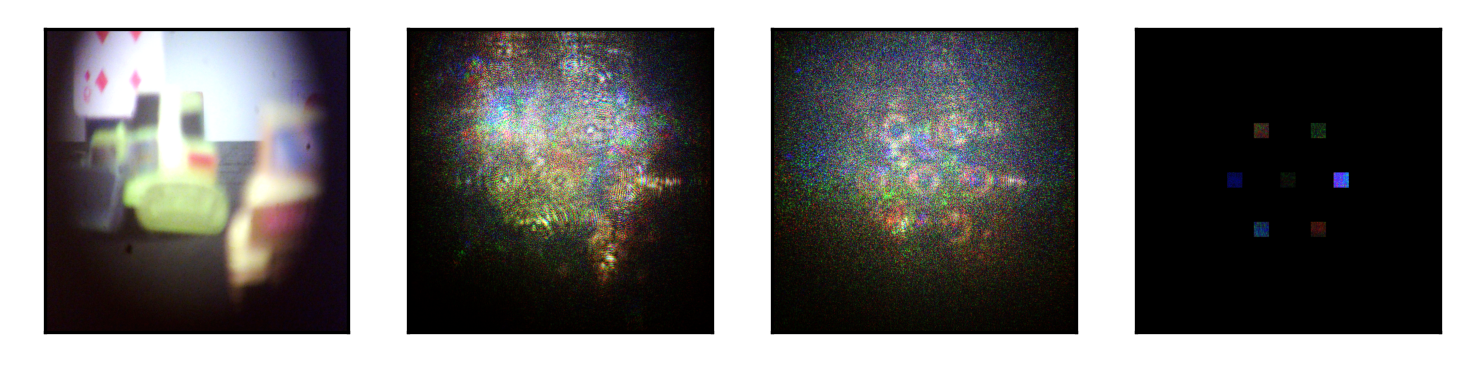

[0.30053602 0.19420491 0.20180056 0.07989013 1.02539553 0.3442518
 0.20063614]


In [20]:
predict(15,test_images,test_labels,draw_tag=1)

([], [])

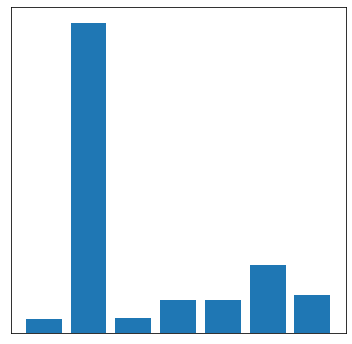

In [21]:

plt.rcParams['axes.facecolor']='w'
a = np.arange(7)
b = np.array([0.02538309, 0.5412823,  0.0270913,  0.05818347, 0.05815491, 0.11985323,
 0.0670795])
plt.figure(figsize=(6,6))
plt.bar(a,b)#,color = 'gray'
plt.xticks([])
plt.yticks([])


In [33]:
def test(x_path, label):
    t_ds = get_dataset(x_path, label, 'test')
    total, correct = 0, 0
    for item in t_ds:
        x, y = item[0], item[1]
        y = tf.cast(y,dtype=tf.int64)
        predict = model(x)
        if LOSS_CHOSE == 'part_mse':
            predict = part_mse_props(predict)[0]
        elif LOSS_CHOSE == 'mse':
            predict = mse_props(predict)
        res = tf.argmax(predict, axis=1)
        total += tf.cast(tf.shape(res)[0],dtype=tf.int64)
        correct += tf.reduce_sum(tf.cast(res == y,dtype=tf.int64))
        correct = tf.cast(correct,dtype=tf.int64)
        total = tf.cast(total, dtype=tf.int64)
    print('total:{}'.format(total))
    print('correct ratio:{}'.format(correct / total))
test(test_images,test_labels)

total:200
correct ratio:0.895


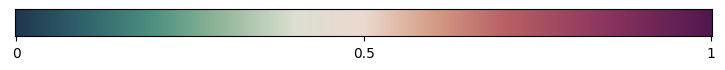

In [16]:
#Custom colorbar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormaps
cdict = {'red': ((0.0, 32/255, 32/255), 
                 (0.1, 49/255, 49/255), 
                 (0.2, 78/255, 78/255),  
                 (0.3, 150/255, 150/255),
                 (0.4, 220/255, 220/255),
                 (0.5, 236/255, 236/255),
                 (0.6, 212/255, 212/255),
                 (0.7, 184/255, 184/255),
                 (0.85, 139/255, 139/255),
                 (1.0, 80/255, 80/255)),
        
        #
       'green': ((0.0, 54/255, 54/255), 
                 (0.1, 100/255, 100/255), 
                 (0.2, 146/255, 146/255),  
                 (0.3, 184/255, 184/255),
                 (0.4, 223/255, 223/255),
                 (0.5, 217/255, 217/255),
                 (0.6, 156/255, 156/255),
                 (0.7, 98/255, 98/255),
                 (0.85, 52/255, 52/255),
                 (1.0, 24/255, 24/255)), 
        #
        'blue': ((0.0, 79/255, 79/255), 
                 (0.1, 108/255, 108/255), 
                 (0.2, 128/255, 128/255),  
                 (0.3, 155/255, 155/255),
                 (0.4, 210/255, 210/255),
                 (0.5, 207/255, 207/255),
                 (0.6, 135/255, 135/255),
                 (0.7, 101/255, 101/255),
                 (0.85, 94/255, 94/255),
                 (1.0, 78/255, 78/255))}

cmap1 = LinearSegmentedColormap('Rd_Bl_Rd', cdict, 256)
im = np.outer(np.ones(10), np.linspace(0, 255, 256))
fig = plt.figure(figsize=(9, 2))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(np.linspace(0, 255, 3))
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([])
ax.set_yticklabels([])
ax.imshow(im, interpolation='nearest', cmap=cmap1)

C:\Users\dell\AppData\Local\Temp\ipykernel_14428\1844540626.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(t, r, c.T,norm=norm,cmap=cmap1)  #plot the colormesh on axis with colormap


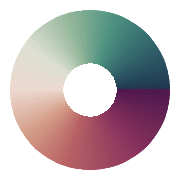

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl

# If displaying in a Jupyter notebook:
# %matplotlib inline 

# Generate a figure with a polar projection
fg = plt.figure(figsize=(2,2))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = mpl.colors.Normalize(0, 2*np.pi) 

# Plot a color mesh on the polar plot
# with the color set by the angle

n = 200  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(.6,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm,cmap=cmap1)  #plot the colormesh on axis with colormap
ax.set_yticklabels([])                   #turn of radial tick labels (yticks)
ax.set_xticklabels([])   
ax.tick_params(pad=12,labelsize=24)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False) 

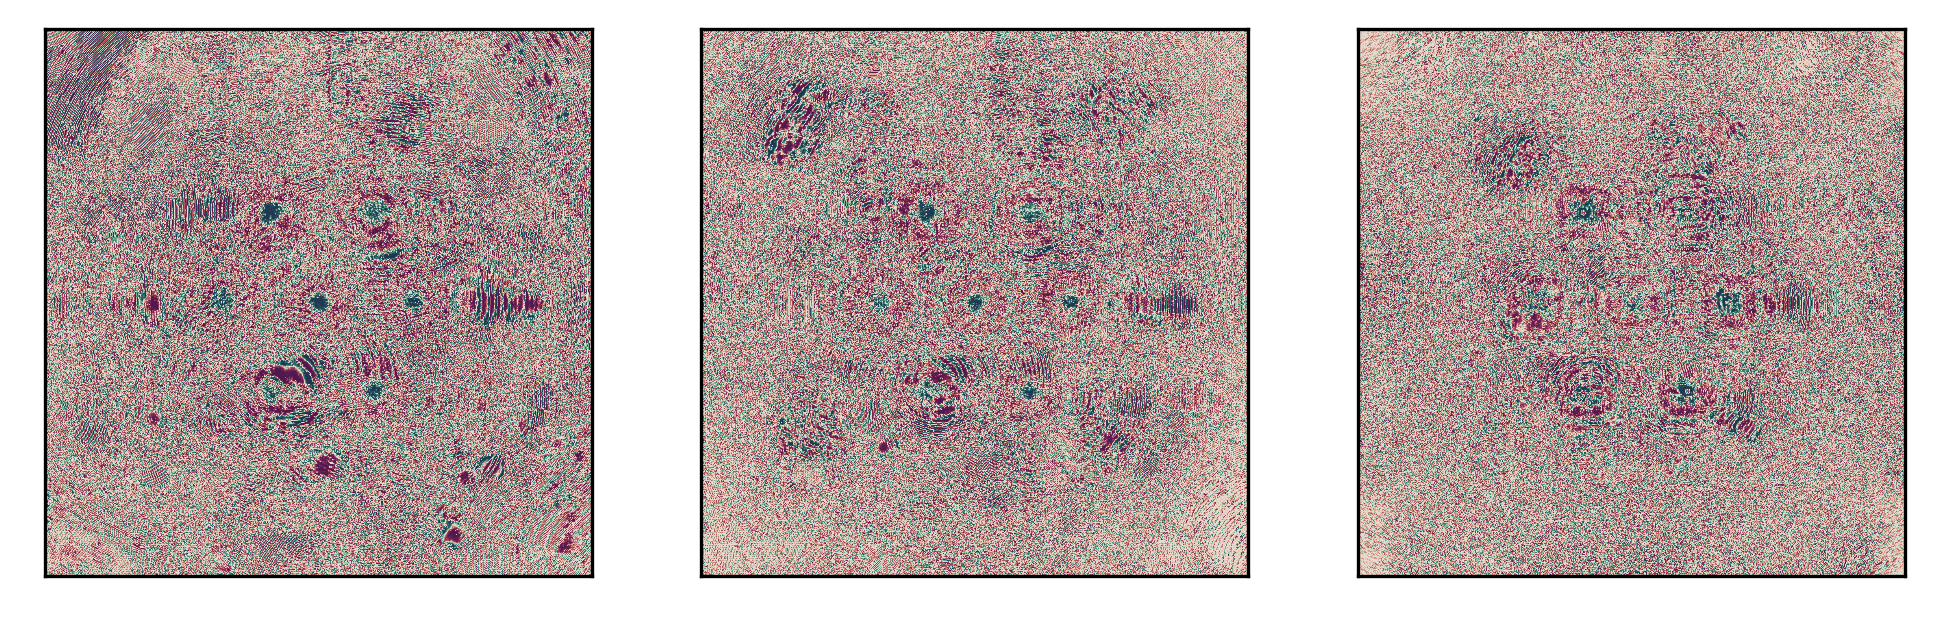

In [26]:
weights = model.get_weights()
fig,ax = plt.subplots(1,3,dpi=300,figsize=(8,8))
for i in range(3):
    h = weights[i]
    if model.is_hight == False:
        h = 2e-6 * tf.exp(25*h) / (tf.exp(25*h) + 1)#5*h
    plt.sca(ax[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(h,vmin=0,vmax=2e-6,cmap=cmap1)
#     plt.colorbar(fraction=0.05)
plt.show()